### Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotNormal
import random
import optuna
import tensorflow as tf

In [113]:
# Plot function

def plot_feature(dataset:pd.DataFrame, featureName:str):
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 10))

    dataset[['date_forecast', featureName]].set_index("date_forecast").plot(ax=axs, title=featureName, color='red')

# Data preperation

In [114]:
# Get data, combine and sort

data_test_A = pd.read_csv("current_csv_files/data_test_A.csv", index_col='Unnamed: 0')
data_test_B = pd.read_csv("current_csv_files/data_test_B.csv", index_col='Unnamed: 0')
data_test_C = pd.read_csv("current_csv_files/data_test_C.csv", index_col='Unnamed: 0')

data_test_ALL = pd.concat([data_test_A, data_test_B, data_test_C], ignore_index=True)
data_test_ALL = data_test_ALL.sort_values(['date_forecast', 'A', 'B', 'C'], ascending=[True, False, False, False])
#data_test_ALL = data_test_ALL.set_index('date_forecast')
data_test_ALL.rename(columns={'pv_measurement': 'target'}, inplace=True)

In [115]:
# Split data

data_ALL = data_test_ALL[data_test_ALL['train'] == 1]
test_ALL = data_test_ALL[data_test_ALL['train'] == 0].drop('target', axis='columns')

In [116]:
test_ALL[['A', 'B', 'C']]

,A,B,C
34061,1,0,0
67600,0,1,0
94391,0,0,1
34062,1,0,0
67601,0,1,0
...,...,...,...
68318,0,1,0
95109,0,0,1
34780,1,0,0
68319,0,1,0


In [117]:
# Separate features and target variable
X = data_ALL.drop('target', axis='columns')
y = data_ALL[['date_forecast', 'target']]

In [118]:
# Split data
"""
"""
def split_data(df, percent):
    split_index = int( np.floor( len(df)*percent ) )
    df_first = df[:split_index]
    df_last = df[split_index:]
    return df_first, df_last

train_percent = 0.94 # Of all
val_percent = 0.5 # Of non-train

X_train, X_non_train = split_data(X, train_percent)
X_val, X_test = split_data(X_non_train, val_percent)

y_train, y_non_train = split_data(y, train_percent)
y_val, y_test = split_data(y_non_train, val_percent)

X_kaggle = test_ALL


In [119]:
# Sample DataFrame creation.
# Assuming df is your original DataFrame and 'date' is the column with dates.
# df = pd.DataFrame({'date': pd.date_range(start='2022-01-01', periods=100, freq='D'), 'data': range(100)})

# Make sure 'date' column is datetime type
"""
"""
X['date_forecast'] = pd.to_datetime(X['date_forecast'])
y['date_forecast'] = pd.to_datetime(y['date_forecast'])

# Define your date range
start_date = "2022-04-01 00:00:00"
end_date = "2022-08-03 23:00:00"

# Convert strings to datetime
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter rows within the date range
mask_X = (X['date_forecast'] >= start_date) & (X['date_forecast'] <= end_date)
mask_y = (y['date_forecast'] >= start_date) & (y['date_forecast'] <= end_date)
X_val = X.loc[mask_X]
y_val = y.loc[mask_y]

# Pop out rows within the date range if you want to remove them from the original df
"""
X_train = X.loc[~mask_X]
y_train = y.loc[~mask_y]
"""


/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/3628176894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['date_forecast'] = pd.to_datetime(y['date_forecast'])


'\nX_train = X.loc[~mask_X]\ny_train = y.loc[~mask_y]\n'

In [120]:
# Load X_test_kaggle, best sub on kaggle, sort properly (hell)

test_ALL_to_sub = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_to_sub_ABC = test_ALL_to_sub.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
y_hat_kaggle = pd.read_csv("teo_subs/kaggle_149.csv", index_col='id')
test_ALL_to_sub_ABC['new_index'] = range(2160)
test_ALL_to_sub_ABC = test_ALL_to_sub_ABC.set_index('new_index')
test_ALL_to_sub_ABC['y_hat_kaggle'] = y_hat_kaggle
test_ALL_to_sub_sorted = test_ALL_to_sub_ABC.sort_values(['date_forecast', 'A', 'B', 'C'], ascending=[True, False, False, False])
test_ALL_to_sub_sorted = test_ALL_to_sub_sorted.set_index('date_forecast')
y_hat = test_ALL_to_sub_sorted['y_hat_kaggle']

In [121]:
# Filter by summer months

y = y[ X['date_forecast'].dt.month.between(4, 8) ]
X = X[ X['date_forecast'].dt.month.between(4, 8) ]


In [122]:
X.drop('date_forecast', axis='columns', inplace=True)
y.drop('date_forecast', axis='columns', inplace=True)

X_train.drop('date_forecast', axis='columns', inplace=True)
y_train.drop('date_forecast', axis='columns', inplace=True)

X_non_train.drop('date_forecast', axis='columns', inplace=True)
y_non_train.drop('date_forecast', axis='columns', inplace=True)

X_val.drop('date_forecast', axis='columns', inplace=True)
y_val.drop('date_forecast', axis='columns', inplace=True)

X_test.drop('date_forecast', axis='columns', inplace=True)
y_test.drop('date_forecast', axis='columns', inplace=True)

X_kaggle.drop('date_forecast', axis='columns', inplace=True)


/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/2066373975.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop('date_forecast', axis='columns', inplace=True)
/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/2066373975.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.drop('date_forecast', axis='columns', inplace=True)


In [123]:
# Prepare features for scaling

feature_dont_touch = [
    'date_forecast',
    'is_day:idx',
    'is_in_shadow:idx',
    'pv_measurement',
    'est',
    'train',
    'A',
    'B',
    'C',
    'precip_type_0',
    'precip_type_1',
    'daily_sinus',
    'annual_sinus',
    'bad_cloud_data',
    'open_sky'
]

feature_to_standardize = [
    'absolute_humidity_2m:gm3',
    'air_density_2m:kgm3',
    'dew_point_2m:K',
    'pressure_100m:hPa',
    'relative_humidity_1000hPa:p',
    't_1000hPa:K',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    #'clear_sky_rad_CD', # Central difference

    # Kinda useless
    #'pressure_50m:hPa',
    #'msl_pressure:hPa',
    #'sfc_pressure:hPa',
]

feature_to_normalize = [
    'cloud_base_agl:m_y',
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'precip_5min:mm',
    'rain_water:kgm2',
    'snow_water:kgm2',
    'super_cooled_liquid_water:kgm2',
    'clear_sky_rad:W',
    'diffuse_rad:W',
    'direct_rad:W',
    'direct_rad:W_lag_avg', # Lag
    'direct_rad:W_lead_avg', # Lead
    'effective_cloud_cover:p',
    'sun_azimuth:d',
    'total_cloud_cover:p',
    'visibility:m',
    'wind_speed_10m:ms',
    'sun_elevation:d', # Clipped version
    'year',
    'month',
    'day',

    # Kinda useless
    #'fresh_snow_12h:cm',
    #'fresh_snow_24h:cm'
]


In [124]:
# Scale features

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

for feature in feature_to_standardize:
    #X_train[feature] = standard_scaler.fit_transform(X_train[[feature]])
    X[feature] = standard_scaler.fit_transform(X[[feature]])
    
    X_non_train[feature] = standard_scaler.transform(X_non_train[[feature]])
    X_val[feature] = standard_scaler.transform(X_val[[feature]])
    X_test[feature] = standard_scaler.transform(X_test[[feature]])
    X_kaggle[feature] = standard_scaler.transform(X_kaggle[[feature]])
    

for feature in feature_to_normalize:
    #X_train[feature] = standard_scaler.fit_transform(X_train[[feature]])
    X[feature] = min_max_scaler.fit_transform(X[[feature]])
    
    X_non_train[feature] = min_max_scaler.transform(X_non_train[[feature]])
    X_val[feature] = min_max_scaler.transform(X_val[[feature]])
    X_test[feature] = min_max_scaler.transform(X_test[[feature]])
    X_kaggle[feature] = min_max_scaler.transform(X_kaggle[[feature]])

/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/337045013.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feature] = standard_scaler.transform(X_test[[feature]])
/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/337045013.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feature] = standard_scaler.transform(X_test[[feature]])
/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_21267/337045013.py:12: SettingWithCopyWarning: 
A value is trying to be

In [125]:
X.shape, y.shape

((35062, 43), (35062, 1))

# Cat Model

In [126]:
from catboost import CatBoostRegressor

catModel = CatBoostRegressor(objective="MAE", random_seed=42, boosting_type="Plain", depth=7, l2_leaf_reg=3, iterations=1000, rsm=0.15)

catModel_A = CatBoostRegressor(objective="MAE", random_seed=42)
catModel_B = CatBoostRegressor(objective="MAE", random_seed=42)
catModel_C = CatBoostRegressor(objective="MAE", random_seed=42)


In [127]:
catModel.fit(X, y)

0:	learn: 532.0563385	total: 11.1ms	remaining: 11.1s
1:	learn: 525.7812309	total: 19.6ms	remaining: 9.8s
2:	learn: 517.8556920	total: 26.6ms	remaining: 8.85s
3:	learn: 504.4626337	total: 33.2ms	remaining: 8.27s
4:	learn: 497.6939282	total: 40.5ms	remaining: 8.07s
5:	learn: 485.1113959	total: 47.4ms	remaining: 7.86s
6:	learn: 473.5679779	total: 55.4ms	remaining: 7.85s
7:	learn: 462.2387553	total: 62.6ms	remaining: 7.76s
8:	learn: 450.2971949	total: 70.1ms	remaining: 7.72s
9:	learn: 446.0532145	total: 76.6ms	remaining: 7.58s
10:	learn: 435.6388999	total: 81.6ms	remaining: 7.34s
11:	learn: 430.2822573	total: 88.3ms	remaining: 7.27s
12:	learn: 419.9926508	total: 94.6ms	remaining: 7.18s
13:	learn: 410.5426093	total: 102ms	remaining: 7.21s
14:	learn: 401.3519792	total: 108ms	remaining: 7.11s
15:	learn: 392.3384570	total: 115ms	remaining: 7.06s
16:	learn: 384.1584344	total: 121ms	remaining: 7.02s
17:	learn: 380.1808212	total: 128ms	remaining: 6.96s
18:	learn: 376.4271643	total: 135ms	remainin

In [128]:
# Pred with cat
pred = catModel.predict(X_kaggle)
MAE = mean_absolute_error(pred, y_hat)
print(MAE)


63.182711148489545


In [129]:
# df for merging and sorting
test_ALL_merge = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_merge['CAT'] = pred


# Correctly sort test data for submission
test_ALL_merge_sorted = test_ALL_merge.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
test_ALL_merge_sorted['id'] = range(2160)
test_ALL_merge_sorted = test_ALL_merge_sorted.set_index('id')
test_ALL_merge_sorted['id'] = range(2160)

In [130]:
DNN = pd.read_csv("teo_subs/teo_sub_12.csv", index_col='id')

df_merge = pd.DataFrame()
df_merge['CAT'] = test_ALL_merge_sorted['CAT']
df_merge['DNN'] = DNN
df_merge['avg'] = df_merge.mean(axis='columns')


In [131]:
df_merge

,CAT,DNN,avg
id,,,
0,0.112827,0.000000,0.056413
1,0.113599,0.000000,0.056799
2,0.114556,0.000000,0.057278
3,68.240636,0.000000,34.120318
4,367.589641,359.026782,363.308212
...,...,...,...
2155,28.625287,25.651803,27.138545
2156,5.488488,8.910144,7.199316
2157,8.969065,0.000000,4.484532


In [132]:
MAE_avg = mean_absolute_error(df_merge['DNN'], y_hat_kaggle)
print(MAE_avg)

49.334743644142186


MAE:  47.40048543090414


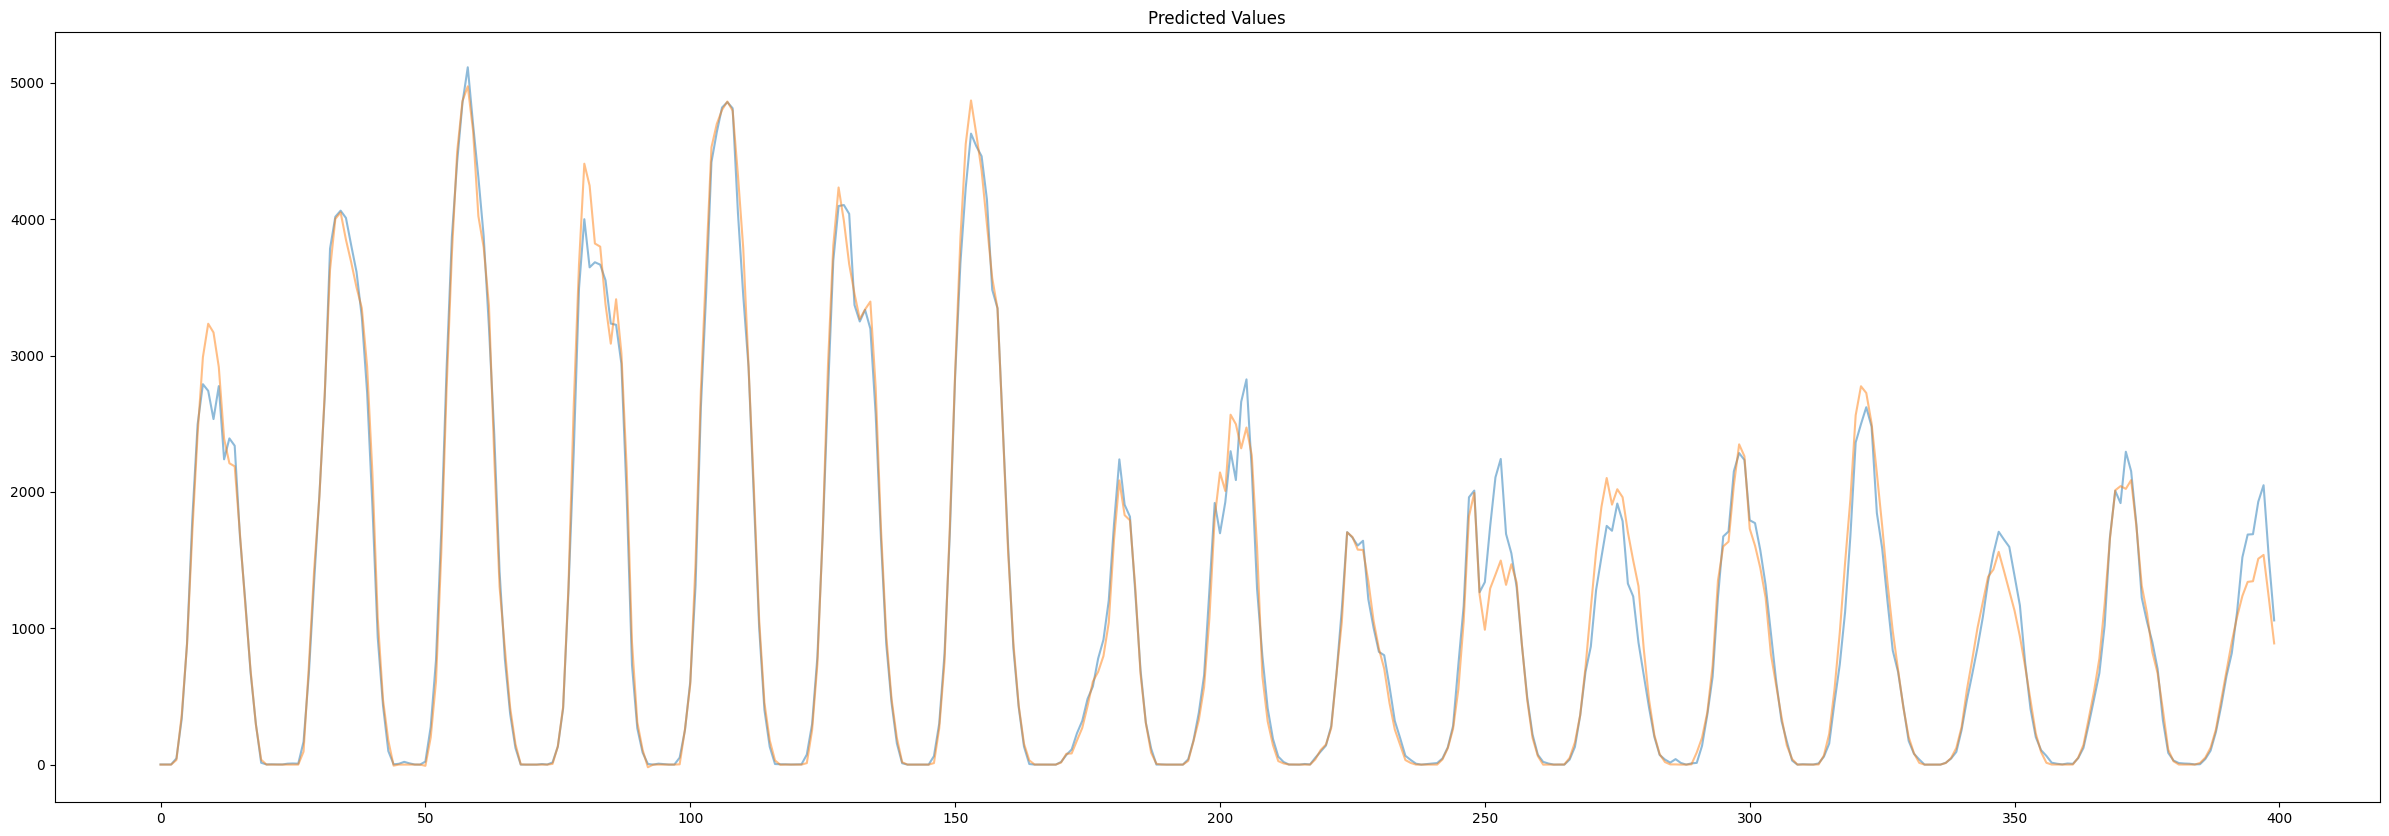

In [139]:
# Comparison to best sub on kaggle
this = df_merge['avg']
that = y_hat_kaggle

print("MAE: ", mean_absolute_error(this, that))

slide = 0
start = 0 + slide
stop = 400 + slide

plt.figure(figsize=(30, 10))
plt.plot(range(start, stop), that.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), this.iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [140]:
df_merge['CAT'].to_csv("teo_subs/teo_sub_14.csv", index=True)

# DNN Model training

In [99]:
class CustomModelCheckpoint(Callback):
    def __init__(self, best_weights, best_epochs, i):
        self.best_weights = best_weights  # Dictionary to store best weights
        self.best_epochs = best_epochs    # Dictionary to store best epoch numbers
        self.best_loss = np.inf
        self.model_index = i  # Index to handle the specific model in the list

    def on_epoch_end(self, epoch, logs=None):
        # Monitor the validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_loss:
            # Update the best loss, best weights, and best epoch
            self.best_loss = current_val_loss
            self.best_weights[self.model_index] = self.model.get_weights()
            self.best_epochs[self.model_index] = epoch
            

In [100]:
def objective(trial):
    
    trial_params = {
        'seed': trial.suggest_int('seed', 1, 100),
        'N': 1,
        'n_neurons_1': trial.suggest_int('n_neurons_1', 150, 200),
        'n_neurons_2': trial.suggest_int('n_neurons_2', 120, 180),
        'n_neurons_3': trial.suggest_int('n_neurons_3', 100, 120),
        'n_neurons_4': trial.suggest_int("n_neurons_4", 60, 100),
        'Dropout': trial.suggest_float('Dropout', 0.0, 0.2),
        'kernel_regularizer': trial.suggest_float('kernel_regularizer', 0.0, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.001),
        'beta_1': trial.suggest_float('beta_1', 0.80, 0.95),
        'min_delta': trial.suggest_float('min_delta', 100, 1000),
        'patience': 10, #trial.suggest_int('patience', 3, 8),
        'batch_size': trial.suggest_categorical("batch_size", [16, 32])
    }

    s = trial_params['seed']
    np.random.seed(s)
    random.seed(s)
    tf.random.set_seed(s)

    N = trial_params['N']
    nets = []
    init = 'HeNormal'

    # Initialize dictionary to store the best weights for each model
    best_weights_during_training = {}
    best_epochs_during_training = {}

    for i in range(N):
        # Define the Keras model
        model = Sequential([
            Dense(trial_params["n_neurons_1"], input_dim=X_train.shape[1], activation='tanh', kernel_initializer=init),
            Dropout(0.1, (trial_params["n_neurons_1"],)),
            Dense(trial_params["n_neurons_2"], activation='relu', kernel_initializer=init, kernel_regularizer=l2(trial_params["kernel_regularizer"])),
            Dense(trial_params["n_neurons_3"], activation='relu', kernel_initializer=init),
            Dense(trial_params["n_neurons_4"], activation='relu', kernel_initializer=init),
            Dense(1, activation='relu', kernel_initializer=init)
        ])
        nets.append(model)

        opt = Adam(learning_rate=trial_params["learning_rate"], beta_1=trial_params["beta_1"])
        model.compile(loss='mean_absolute_error', optimizer=opt)

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=trial_params['min_delta'], patience=trial_params['patience'])

        # Create an instance of the custom checkpoint for the current model
        custom_checkpoint = CustomModelCheckpoint(best_weights_during_training, best_epochs_during_training, i)
        
        # Fit the model
        history = model.fit(
            X, y,
            validation_data=(X_kaggle, y_hat),
            #validation_split=0.2,
            epochs=100,
            batch_size=trial_params['batch_size'],
            callbacks=[early_stopping, custom_checkpoint],
            verbose=0,
            use_multiprocessing=True, workers=4,
        )


        if i not in best_weights_during_training:
            # If the model didn't improve, just save the last weights and epoch number
            best_weights_during_training[i] = model.get_weights()
            best_epochs_during_training[i] = len(history.epoch)


    # Set weights and print epoch
    for i in range(N):
        nets[i].set_weights(best_weights_during_training[i])
        print("Best epoch: ", best_epochs_during_training[i] +1) # It's plus one for some reason. Idk it works
    
    # Make kaggle prediction
    best_kaggle_preds = []

    for i in range(N):
        best_kaggle_preds.append(nets[i].predict(X_kaggle, verbose=0).ravel())
    
    # Create dataframe for kaggle pred
    df_kaggle_preds = pd.DataFrame(best_kaggle_preds).T
    df_kaggle_preds['avg'] = df_kaggle_preds.mean(axis='columns')

    # Merge with kaggle_test data
    test_ALL_merge = pd.read_csv("current_csv_files/test_ALL.csv")
    test_ALL_merge['prediction'] = df_kaggle_preds['avg']
    

    # Correctly sort test data for submission
    test_ALL_merge_sorted = test_ALL_merge.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
    test_ALL_merge_sorted['id'] = range(2160)
    test_ALL_merge_sorted = test_ALL_merge_sorted.set_index('id')
    test_ALL_merge_sorted['id'] = range(2160)

    # Comparison to best sub on kaggle
    #best_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')
    objective_metric = mean_squared_error(df_kaggle_preds['avg'], y_hat)
    print(trial.number," MAE: ", mean_absolute_error(df_kaggle_preds['avg'], y_hat))

    file_loc = "dnn_kaggle3/optuna_sub_"+str(trial.number)+".csv"
    test_ALL_merge_sorted[['id', 'prediction']].to_csv(file_loc, index=False)

    return objective_metric
    

In [101]:
# Optuna study

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

print('Best hyperparameters:', study.best_params)
print('Best MSE:', study.best_value)


#0, 4

[I 2023-11-11 00:14:40,719] A new study created in memory with name: no-name-aeb6873e-b17f-4cf6-b91b-9fd54fdb87f4
[I 2023-11-11 00:15:32,010] Trial 0 finished with value: 29791.345966722438 and parameters: {'seed': 47, 'n_neurons_1': 166, 'n_neurons_2': 160, 'n_neurons_3': 106, 'n_neurons_4': 70, 'Dropout': 0.139812669512829, 'kernel_regularizer': 0.24168289846239438, 'learning_rate': 0.000676112834116884, 'beta_1': 0.8918510855269829, 'min_delta': 257.3517518992583, 'batch_size': 16}. Best is trial 0 with value: 29791.345966722438.


Best epoch:  9
0  MAE:  87.80970465769559


[I 2023-11-11 00:16:03,033] Trial 1 finished with value: 48698.9160684704 and parameters: {'seed': 94, 'n_neurons_1': 166, 'n_neurons_2': 179, 'n_neurons_3': 119, 'n_neurons_4': 77, 'Dropout': 0.16323155725977265, 'kernel_regularizer': 0.23282671034113445, 'learning_rate': 0.0005788464355452922, 'beta_1': 0.8117427991731005, 'min_delta': 704.190593739009, 'batch_size': 32}. Best is trial 0 with value: 29791.345966722438.


Best epoch:  10
1  MAE:  107.16804877757635


[I 2023-11-11 00:16:32,019] Trial 2 finished with value: 19579.525755258703 and parameters: {'seed': 87, 'n_neurons_1': 182, 'n_neurons_2': 177, 'n_neurons_3': 119, 'n_neurons_4': 84, 'Dropout': 0.17795683710866975, 'kernel_regularizer': 0.19093635567889086, 'learning_rate': 0.0008787951975766264, 'beta_1': 0.8248033198234778, 'min_delta': 566.9438253245112, 'batch_size': 32}. Best is trial 2 with value: 19579.525755258703.


Best epoch:  7
2  MAE:  65.9132963411223


[I 2023-11-11 00:17:01,190] Trial 3 finished with value: 23159.71511971922 and parameters: {'seed': 19, 'n_neurons_1': 178, 'n_neurons_2': 141, 'n_neurons_3': 103, 'n_neurons_4': 79, 'Dropout': 0.1045844417446123, 'kernel_regularizer': 0.20823524599043294, 'learning_rate': 0.0006442027356581531, 'beta_1': 0.913063087403868, 'min_delta': 161.87460581868987, 'batch_size': 32}. Best is trial 2 with value: 19579.525755258703.


Best epoch:  1
3  MAE:  81.29971029568208


[I 2023-11-11 00:17:47,351] Trial 4 finished with value: 39255.78045953774 and parameters: {'seed': 87, 'n_neurons_1': 178, 'n_neurons_2': 135, 'n_neurons_3': 104, 'n_neurons_4': 84, 'Dropout': 0.0011752293284174931, 'kernel_regularizer': 0.10510413142123823, 'learning_rate': 0.0007335553887821355, 'beta_1': 0.9081916905492892, 'min_delta': 783.8166913503555, 'batch_size': 16}. Best is trial 2 with value: 19579.525755258703.


Best epoch:  9
4  MAE:  94.09078942325374


[I 2023-11-11 00:18:13,393] Trial 5 finished with value: 1267236.6539165655 and parameters: {'seed': 52, 'n_neurons_1': 181, 'n_neurons_2': 126, 'n_neurons_3': 116, 'n_neurons_4': 76, 'Dropout': 0.1936833036391447, 'kernel_regularizer': 0.025742704777581702, 'learning_rate': 0.0006809047125859179, 'beta_1': 0.8227987329686796, 'min_delta': 496.25209661047404, 'batch_size': 32}. Best is trial 2 with value: 19579.525755258703.


Best epoch:  1
5  MAE:  564.7256816546321


[I 2023-11-11 00:19:02,582] Trial 6 finished with value: 15876.417238662902 and parameters: {'seed': 95, 'n_neurons_1': 178, 'n_neurons_2': 176, 'n_neurons_3': 120, 'n_neurons_4': 62, 'Dropout': 0.17768949473352147, 'kernel_regularizer': 0.16587762725020713, 'learning_rate': 0.0007513821624619585, 'beta_1': 0.9311264909786767, 'min_delta': 813.9296231133162, 'batch_size': 16}. Best is trial 6 with value: 15876.417238662902.


Best epoch:  9
6  MAE:  69.39402571405685


[I 2023-11-11 00:19:52,497] Trial 7 finished with value: 13170.6407325512 and parameters: {'seed': 18, 'n_neurons_1': 198, 'n_neurons_2': 168, 'n_neurons_3': 120, 'n_neurons_4': 61, 'Dropout': 0.004808017834743206, 'kernel_regularizer': 0.1242061997156143, 'learning_rate': 0.0008860987932280755, 'beta_1': 0.8076954102532441, 'min_delta': 292.15409435126696, 'batch_size': 16}. Best is trial 7 with value: 13170.6407325512.


Best epoch:  9
7  MAE:  58.614824947537606


[W 2023-11-11 00:20:06,251] Trial 8 failed with parameters: {'seed': 59, 'n_neurons_1': 150, 'n_neurons_2': 157, 'n_neurons_3': 115, 'n_neurons_4': 68, 'Dropout': 0.09263350275901355, 'kernel_regularizer': 0.016369301496110867, 'learning_rate': 0.0008060232244039095, 'beta_1': 0.8792601118086287, 'min_delta': 456.16647811877215, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_19562/3656269238.py", line 54, in objective
    history = model.fit(
              ^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^

KeyboardInterrupt: 

In [59]:
# Average best pred with new best kaggle sub
df_merge = pd.DataFrame()

df_merge['0'] = pd.read_csv("dnn_kaggle3/optuna_sub_1.csv", index_col='id')
df_merge['1'] = pd.read_csv("dnn_kaggle3/optuna_sub_3.csv", index_col='id')
df_merge['2'] = pd.read_csv("dnn_kaggle3/optuna_sub_6.csv", index_col='id')
df_merge['3'] = pd.read_csv("dnn_kaggle3/optuna_sub_10.csv", index_col='id')
df_merge['4'] = pd.read_csv("dnn_kaggle3/optuna_sub_16.csv", index_col='id')

df_merge

,0,1,2,3,4
id,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,364.760440,278.614000,368.950650,338.633820,444.175000
...,...,...,...,...,...
2155,32.028350,36.053455,8.655926,15.636539,35.884747
2156,16.393675,12.970493,1.146024,0.153641,13.886889
2157,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
df_merge['prediction'] = df_merge.mean(axis='columns')
df_merge['y_hat_kaggle'] = y_hat_kaggle['predict'].to_list()
df_merge

,0,1,2,3,4,prediction,y_hat_kaggle
id,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.141681
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438430
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.138146
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.634729
4,364.760440,278.614000,368.950650,338.633820,444.175000,359.026782,335.761563
...,...,...,...,...,...,...,...
2155,32.028350,36.053455,8.655926,15.636539,35.884747,25.651803,29.307958
2156,16.393675,12.970493,1.146024,0.153641,13.886889,8.910144,4.800279
2157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


MAE:  49.334743644142186


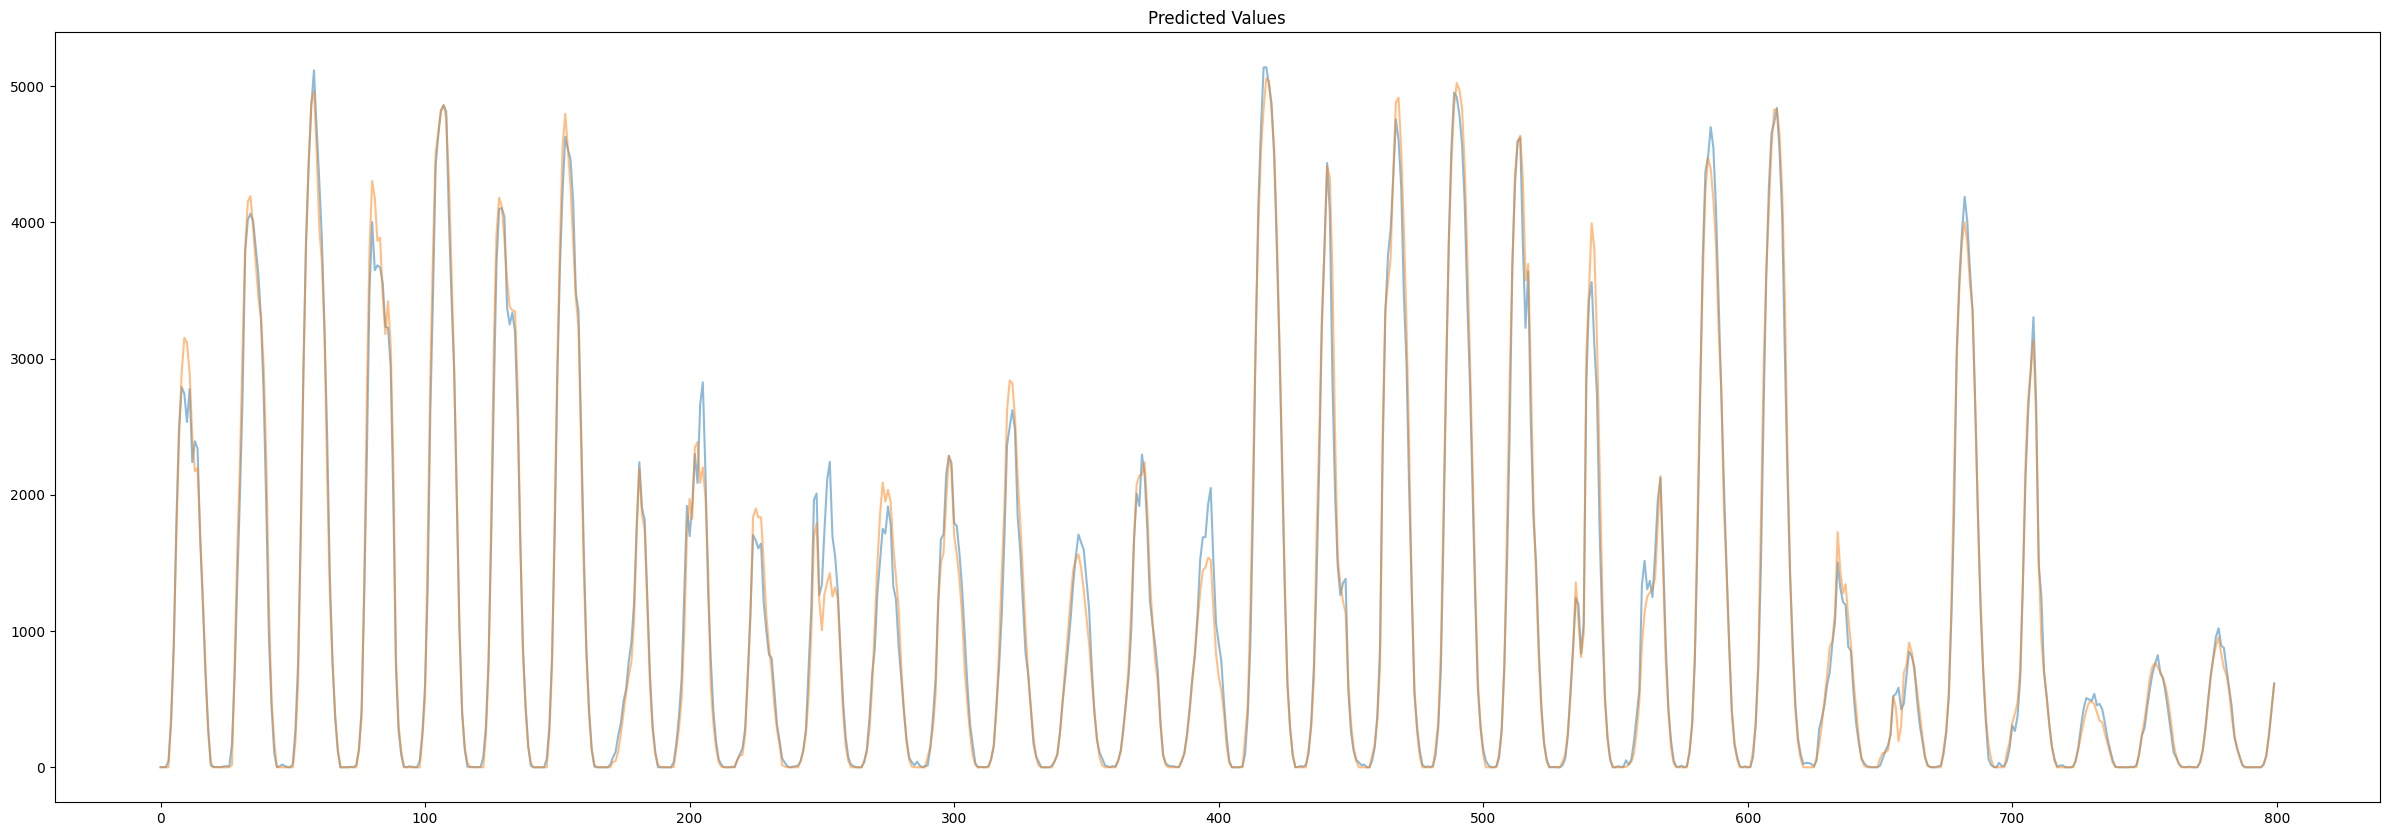

In [66]:
# Comparison to best sub on kaggle
this = df_merge['prediction']
that = df_merge['y_hat_kaggle']

print("MAE: ", mean_absolute_error(this, that))

slide = 0
start = 0 + slide
stop = 800 + slide

plt.figure(figsize=(30, 10))
plt.plot(range(start, stop), that.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), this.iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [67]:
df_merge['prediction'].to_csv("teo_subs/teo_sub_12.csv", index=True)

# Making prediction

In [ ]:
# Make predictions using the best test validation epoch
best_preds = []

for i in range(N):
    nets[i].set_weights(best_weights_during_training[i])
    best_preds.append(nets[i].predict(X_non_train).ravel()) # Select dataset of choice
    print(i, "MAE: ", mean_absolute_error(y_non_train, best_preds[i]))

175/175 [==============================] - 0s 515us/step
0 MAE:  88.9113066837359
175/175 [==============================] - 0s 462us/step
1 MAE:  89.4273040651171
175/175 [==============================] - 0s 475us/step
2 MAE:  91.6874854988511
175/175 [==============================] - 0s 513us/step
3 MAE:  90.31275494481588
175/175 [==============================] - 0s 490us/step
4 MAE:  91.51212414305533
175/175 [==============================] - 0s 767us/step
5 MAE:  91.14033348612026
175/175 [==============================] - 0s 460us/step
6 MAE:  90.87893552901771
175/175 [==============================] - 0s 552us/step
7 MAE:  88.13167835116013
175/175 [==============================] - 0s 465us/step
8 MAE:  91.06386822525626
175/175 [==============================] - 0s 478us/step
9 MAE:  90.03203744051045


In [ ]:
# Create dataframe
df_best_preds = pd.DataFrame(best_preds).T

df_best_preds['avg'] = df_best_preds.mean(axis='columns')

In [ ]:
df_best_preds

,0,1,2,3,4,5,6,7,8,9,avg
0,0.000000,26.770554,18.336561,17.226801,15.353435,20.446899,10.105970,14.716593,5.706990,2.085349,13.074915
1,335.915924,513.566101,275.583221,268.393646,242.171509,378.666229,382.066925,330.249756,316.322876,427.687836,347.062378
2,0.000000,24.011923,5.988428,2.156328,0.896857,4.850194,3.471783,2.623480,1.970294,0.000000,4.596929
3,0.000000,74.680679,11.198603,0.000000,0.000000,15.886543,11.724668,11.861152,10.078298,5.754906,14.118484
4,0.000000,1.166825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116682
...,...,...,...,...,...,...,...,...,...,...,...
5573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


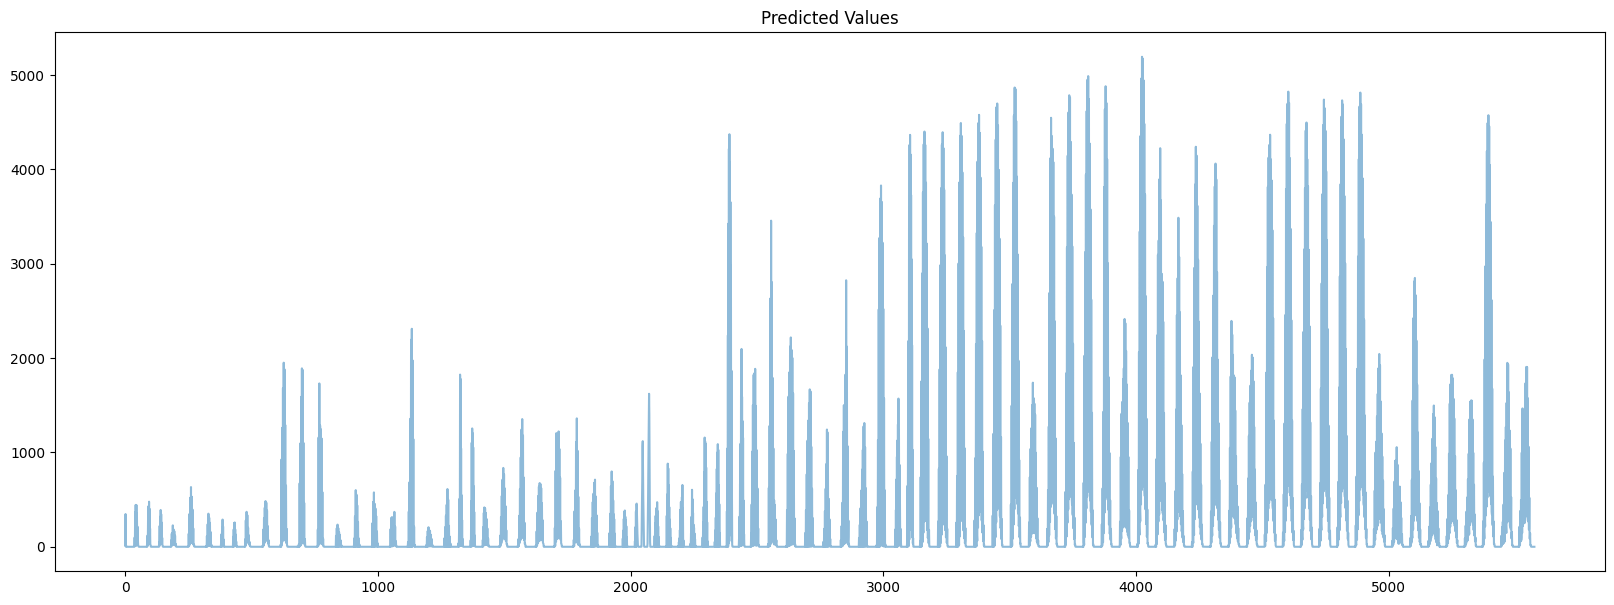

In [ ]:
plt.figure(figsize=(20, 7))
plt.plot(df_best_preds['avg'], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [ ]:
print("MAE: ", mean_absolute_error(y_non_train, df_best_preds['avg']))

MAE:  87.79013393395199


In [ ]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(df_best_preds.iloc[: , :N], y_test) # Select dataset of choice

LinearRegression()

In [ ]:
# Make kaggle prediction
best_kaggle_preds = []

for i in range(N):
    best_kaggle_preds.append(nets[i].predict(X_kaggle).ravel())

68/68 [==============================] - 0s 524us/step


In [ ]:
# Create dataframe for kaggle pred
df_kaggle_preds = pd.DataFrame(best_kaggle_preds).T

df_kaggle_preds['avg'] = df_kaggle_preds.mean(axis='columns')

In [ ]:
kaggle_pred = LR_model.predict(df_kaggle_preds.iloc[: , :N])
kaggle_pred = kaggle_pred.clip(min=0)

In [ ]:
df_kaggle_preds

,0,1,2,3,4,5,6,7,8,9,avg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Merge with kaggle_test data
test_ALL_to_sub = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_to_sub['prediction'] = df_kaggle_preds['avg']

In [ ]:
# Correctly sort test data for submission
test_ALL_sorted = test_ALL_to_sub.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
test_ALL_sorted['id'] = range(2160)

MAE:  111.88395444869694


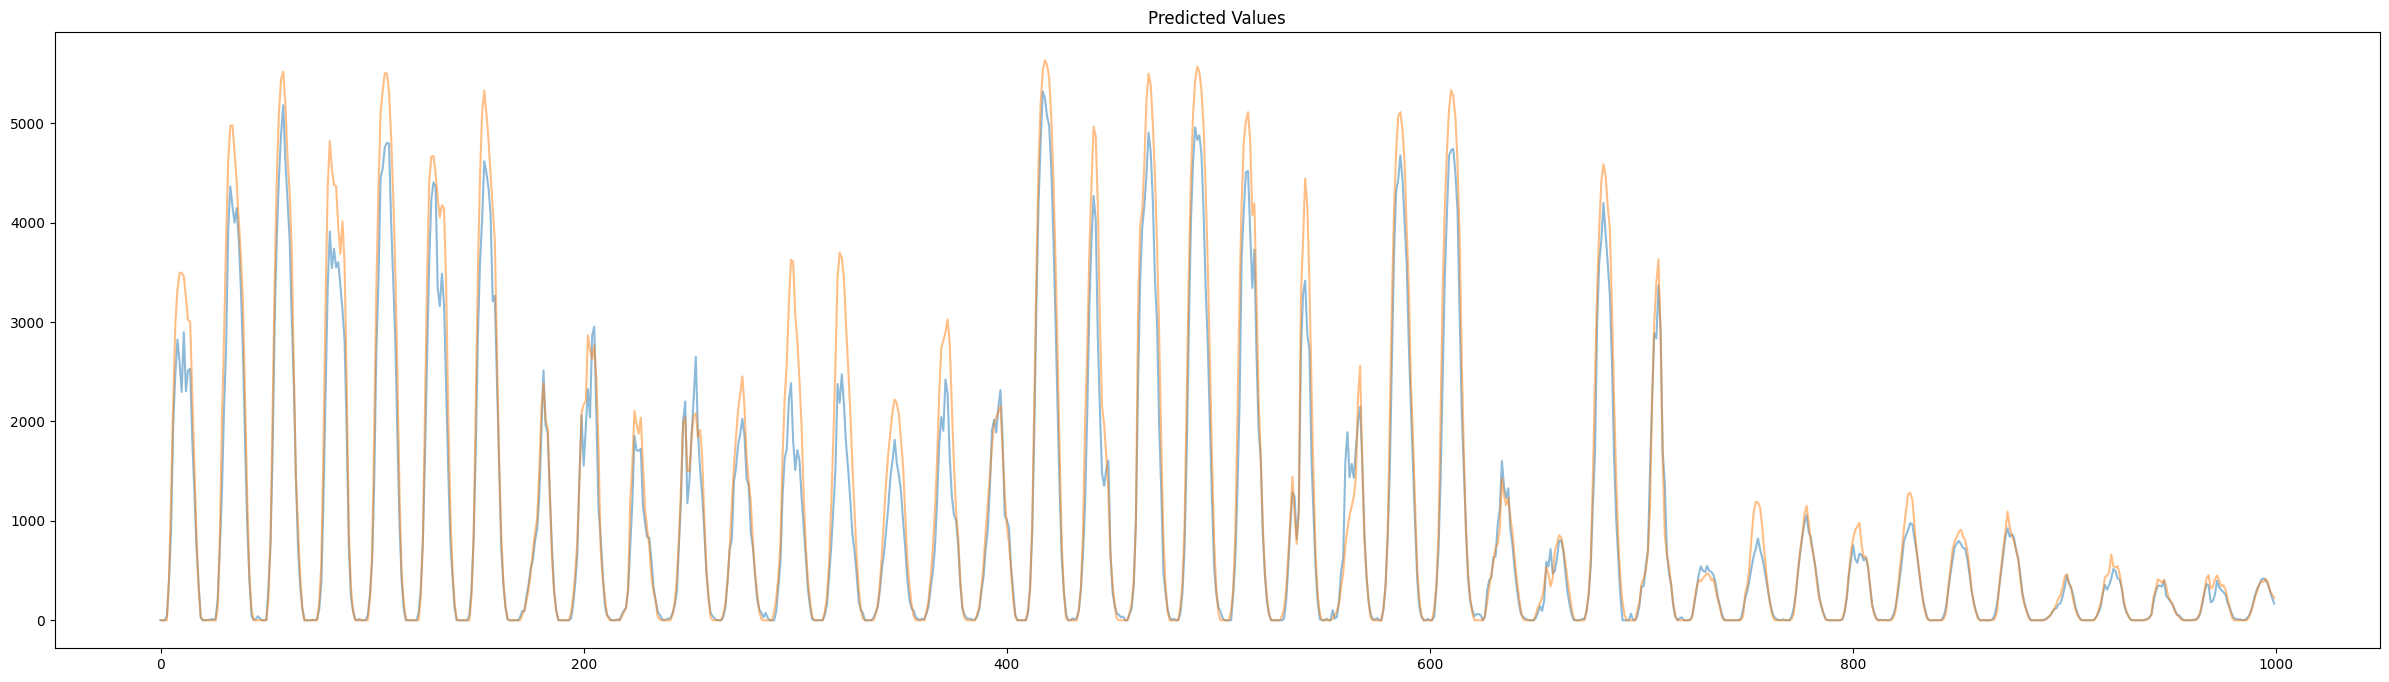

In [ ]:
# Comparison to best sub on kaggle

best_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')
print("MAE: ", mean_absolute_error(test_ALL_sorted['prediction'], best_sub))

slide = 0
start = 0 + slide
stop = 1000 + slide

plt.figure(figsize=(30, 8))
plt.plot(range(start, stop), best_sub.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), test_ALL_sorted['prediction'].iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [ ]:
test_ALL_sorted[['id', 'prediction']].to_csv("teo_subs/teo_sub_10.csv", index=False)

In [ ]:
cat_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')

avg_pred = (cat_sub + test_ALL_sorted['prediction'])/2
avg_pred.to_csv("teo_subs/teo_sub_8.csv")